In [0]:
!pip3 list

Package            Version    
------------------ -----------
attrs              19.1.0     
backcall           0.1.0      
bleach             3.1.0      
Click              7.0        
colorama           0.4.1      
cycler             0.10.0     
decorator          4.4.0      
defusedxml         0.6.0      
entrypoints        0.3        
Flask              1.1.1      
Flask-SocketIO     4.2.1      
ipykernel          5.1.2      
ipython            7.7.0      
ipython-genutils   0.2.0      
ipywidgets         7.5.1      
itsdangerous       1.1.0      
jedi               0.15.1     
Jinja2             2.10.1     
json5              0.8.5      
jsonschema         3.0.2      
jupyter            1.0.0      
jupyter-client     5.3.1      
jupyter-console    6.0.0      
jupyter-core       4.5.0      
jupyterlab         1.0.5      
jupyterlab-server  1.0.0      
kiwisolver         1.1.0      
lz4                2.1.10     
MarkupSafe         1.1.1      
matplotlib         3.1.1      
mistune 

You are using pip version 19.0.3, however version 19.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [0]:
from __future__ import unicode_literals, print_function, division
from torch.utils.data import Dataset

import torch
from io import open
import glob
import os
import numpy as np
import unicodedata
import string
import random
import torch.nn as nn
import time
import math
import syft as sy
import pandas as pd
import random
from syft.frameworks.torch.federated import utils

from syft.workers import WebsocketClientWorker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [0]:
#Load all the files in a certain path
def findFiles(path):
    return glob.glob(path)

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

#convert a string 's' in unicode format to ASCII format
def unicodeToAscii(s):
    return ''.join (
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


In [0]:
data_path = './data/names/*.txt'

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

category_lines = {}
all_categories = []

for filename in findFiles(data_path):
    print(filename)
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines   
    
n_categories = len(all_categories)

print("Amount of categories:" + str(n_categories))

./data/names\Arabic.txt
./data/names\Chinese.txt
./data/names\Czech.txt
./data/names\Dutch.txt
./data/names\English.txt
./data/names\French.txt
./data/names\German.txt
./data/names\Greek.txt
./data/names\Irish.txt
./data/names\Italian.txt
./data/names\Japanese.txt
./data/names\Korean.txt
./data/names\Polish.txt
./data/names\Portuguese.txt
./data/names\Russian.txt
./data/names\Scottish.txt
./data/names\Spanish.txt
./data/names\Vietnamese.txt
Amount of categories:18


In [0]:
class LanguageDataset(Dataset):
    #Constructor is mandatory
        def __init__(self, text, labels, transform=None):
            self.data = text
            self.targets = labels #categories
            #self.to_torchtensor()
            self.transform = transform
        
        def to_torchtensor(self):            
            self.data = torch.from_numpy(self.text, requires_grad=True)
            self.labels = torch.from_numpy(self.targets, requires_grad=True)
        
        def __len__(self):
            #Mandatory
            '''Returns:
                    Length [int]: Length of Dataset/batches
            '''
            return len(self.data)
    
        def __getitem__(self, idx): 
            #Mandatory 
            
            '''Returns:
                     Data [Torch Tensor]: 
                     Target [ Torch Tensor]:
            '''
            sample = self.data[idx]
            target = self.targets[idx]
                    
            if self.transform:
                sample = self.transform(sample)
    
            return sample,target

In [0]:
#The list of arguments for our program. We will be needing most of them soon.
class Arguments():
    def __init__(self):
        self.batch_size = 1
        self.learning_rate = 0.005
        self.epochs = 10000
        self.federate_after_n_batches = 15000
        self.seed = 1
        self.print_every = 200
        self.plot_every = 100
        self.use_cuda = False
        
args = Arguments()

In [0]:
%%latex

\begin{split}
names\_list = [d_1,...,d_n]  \\

category\_list = [c_1,...,c_n] 
\end{split}


Where $n$ is the total amount of data points

<IPython.core.display.Latex object>

In [0]:
#Set of names(X)
names_list = []
#Set of labels (Y)
category_list = []

#Convert into a list with corresponding label.

for nation, names in category_lines.items():
    #iterate over every single name
    for name in names:
        names_list.append(name)      #input data point
        category_list.append(nation) #label
        
#let's see if it was successfully loaded. Each data sample(X) should have its own corresponding category(Y)
print(names_list[1:20])
print(category_list[1:20])

print("\n \n Amount of data points loaded: " + str(len(names_list)))

['Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar']
['Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic']

 
 Amount of data points loaded: 20074


In [0]:
#Assign an integer to every category
categories_numerical = pd.factorize(category_list)[0]
#Let's wrap our categories with a tensor, so that it can be loaded by LanguageDataset
category_tensor = torch.tensor(np.array(categories_numerical), dtype=torch.long)
#Ready to be processed by torch.from_numpy in LanguageDataset
categories_numpy = np.array(category_tensor)

#Let's see a few resulting categories
print(names_list[1200:1210])
print(categories_numpy[1200:1210])

['Said', 'Guirguis', 'Nader', 'Harb', 'Atiyeh', 'Zogby', 'Basara', 'Nassar', 'Kalb', 'Khoury']
[0 0 0 0 0 0 0 0 0 0]


In [0]:
def letterToIndex(letter):
    return all_letters.find(letter)
    
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) #Daniele: len(max_line_size) was len(line)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    #Daniele: add blank elements over here
    return tensor    
    
    
    
def list_strings_to_list_tensors(names_list):
    lines_tensors = []
    for index, line in enumerate(names_list):
        lineTensor = lineToTensor(line)
        lineNumpy = lineTensor.numpy()
        lines_tensors.append(lineNumpy)
        
    return(lines_tensors)

lines_tensors = list_strings_to_list_tensors(names_list)

print(names_list[0])
print(lines_tensors[0])
print(lines_tensors[0].shape)

Khoury
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 

In [0]:
max_line_size = max(len(x) for x in lines_tensors)

def lineToTensorFillEmpty(line, max_line_size):
    tensor = torch.zeros(max_line_size, 1, n_letters) #notice the difference between this method and the previous one
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
        
        #Vectors with (0,0,.... ,0) are placed where there are no characters
    return tensor

def list_strings_to_list_tensors_fill_empty(names_list):
    lines_tensors = []
    for index, line in enumerate(names_list):
        lineTensor = lineToTensorFillEmpty(line, max_line_size)
        lines_tensors.append(lineTensor)
    return(lines_tensors)

lines_tensors = list_strings_to_list_tensors_fill_empty(names_list)

#Let's take a look at what a word now looks like
print(names_list[0])
print(lines_tensors[0])
print(lines_tensors[0].shape)

Khoury
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([19, 1, 57])


In [0]:
#And finally, from a list, we can create a numpy array with all our word embeddings having the same shape:
array_lines_tensors = np.stack(lines_tensors)
#However, such operation introduces one extra dimension (look at the dimension with index=2 having size '1')
print(array_lines_tensors.shape)
#Because that dimension just has size 1, we can get rid of it with the following function call
array_lines_proper_dimension = np.squeeze(array_lines_tensors, axis=2)
print(array_lines_proper_dimension.shape)

(20074, 19, 1, 57)
(20074, 19, 57)


In [0]:

def find_start_index_per_category(category_list):
    categories_start_index = {}
    
    #Initialize every category with an empty list
    for category in all_categories:
        categories_start_index[category] = []
    
    #Insert the start index of each category into the dictionary categories_start_index
    #Example: "Italian" --> 203
    #         "Spanish" --> 19776
    last_category = None
    i = 0
    for name in names_list:
        cur_category = category_list[i]
        if(cur_category != last_category):
            categories_start_index[cur_category] = i
            last_category = cur_category
        
        i = i + 1
        
    return(categories_start_index)

categories_start_index = find_start_index_per_category(category_list)

print(categories_start_index)

{'Arabic': 0, 'Chinese': 2000, 'Czech': 2268, 'Dutch': 2787, 'English': 3084, 'French': 6752, 'German': 7029, 'Greek': 7753, 'Irish': 7956, 'Italian': 8188, 'Japanese': 8897, 'Korean': 9888, 'Polish': 9982, 'Portuguese': 10121, 'Russian': 10195, 'Scottish': 19603, 'Spanish': 19703, 'Vietnamese': 20001}


In [0]:
def randomChoice(l):
    rand_value = random.randint(0, len(l) - 1)
    return l[rand_value], rand_value


def randomTrainingIndex():
    category, rand_cat_index = randomChoice(all_categories) #cat = category, it's not a random animal
    #rand_line_index is a relative index for a data point within the random category rand_cat_index
    line, rand_line_index = randomChoice(category_lines[category])
    category_start_index = categories_start_index[category]
    absolute_index = category_start_index + rand_line_index
    return(absolute_index)

In [0]:
## 3. Step: Model - Recurrent Neural Network

In [0]:
#Two hidden layers, based on simple linear layers

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#Let's instantiate the neural network already:
n_hidden = 128
#Instantiate RNN

device = torch.device("cuda" if args.use_cuda else "cpu")
model = RNN(n_letters, n_hidden, n_categories).to(device)
#The final softmax layer will produce a probability for each one of our 18 categories
print(model)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


In [0]:
#Now let's define our workers. You can either use remote workers or virtual workers

hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning

#alice = sy.VirtualWorker(hook, id="alice")  
#bob = sy.VirtualWorker(hook, id="bob")  
#charlie = sy.VirtualWorker(hook, id="charlie") 

#workers_virtual = [alice, bob]

#If you have your workers operating remotely, like on Raspberry PIs
my_ip="YOUR_IP"
kwargs_websocket_alice = {"host": my_ip, "hook": hook}
alice = WebsocketClientWorker(id="alice", port=8777, **kwargs_websocket_alice)
kwargs_websocket_bob = {"host": my_ip, "hook": hook}
bob = WebsocketClientWorker(id="bob", port=8778, **kwargs_websocket_bob)
workers_virtual = [alice, bob]

In [0]:
#array_lines_proper_dimension = our data points(X)
#categories_numpy = our labels (Y)
langDataset =  LanguageDataset(array_lines_proper_dimension, categories_numpy)

#assign the data points and the corresponding categories to workers.
federated_train_loader = sy.FederatedDataLoader(
            langDataset
            .federate(workers_virtual),
            batch_size=args.batch_size)

In [0]:
## 4. Step - Model Training!

In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def fed_avg_every_n_iters(model_pointers, iter, federate_after_n_batches):
        models_local = {}
        
        if(iter % args.federate_after_n_batches == 0):
            for worker_name, model_pointer in model_pointers.items():
#                #need to assign the model to the worker it belongs to.
                models_local[worker_name] = model_pointer.copy().get()
            model_avg = utils.federated_avg(models_local)
           
            for worker in workers_virtual:
                model_copied_avg = model_avg.copy()
                model_ptr = model_copied_avg.send(worker) 
                model_pointers[worker.id] = model_ptr
                
        return(model_pointers)     

def fw_bw_pass_model(model_pointers, line_single, category_single):
    #get the right initialized model
    model_ptr = model_pointers[line_single.location.id]   
    line_reshaped = line_single.reshape(max_line_size, 1, len(all_letters))
    line_reshaped, category_single = line_reshaped.to(device), category_single.to(device)
    #Firstly, initialize hidden layer
    hidden_init = model_ptr.initHidden() 
    #And now zero grad the model
    model_ptr.zero_grad()
    hidden_ptr = hidden_init.send(line_single.location)
    amount_lines_non_zero = len(torch.nonzero(line_reshaped.copy().get()))
    #now need to perform forward passes
    for i in range(amount_lines_non_zero): 
        output, hidden_ptr = model_ptr(line_reshaped[i], hidden_ptr) 
    criterion = nn.NLLLoss()   
    loss = criterion(output, category_single) 
    loss.backward()
    
    model_got = model_ptr.get() 
    
    #Perform model weights' updates    
    for param in model_got.parameters():
        param.data.add_(-args.learning_rate, param.grad.data)
        
        
    model_sent = model_got.send(line_single.location.id)
    model_pointers[line_single.location.id] = model_sent
    
    return(model_pointers, loss, output)
            
  
    
def train_RNN(n_iters, print_every, plot_every, federate_after_n_batches, list_federated_train_loader):
    current_loss = 0
    all_losses = []    
    
    model_pointers = {}
    
    #Send the initialized model to every single worker just before the training procedure starts
    for worker in workers_virtual:
        model_copied = model.copy()
        model_ptr = model_copied.send(worker) 
        model_pointers[worker.id] = model_ptr

    #extract a random element from the list and perform training on it
    for iter in range(1, n_iters + 1):        
        random_index = randomTrainingIndex()
        line_single, category_single = list_federated_train_loader[random_index]
        #print(category_single.copy().get())
        line_name = names_list[random_index]
        model_pointers, loss, output = fw_bw_pass_model(model_pointers, line_single, category_single)
        #model_pointers = fed_avg_every_n_iters(model_pointers, iter, args.federate_after_n_batches)
        #Update the current loss a
        loss_got = loss.get().item() 
        current_loss += loss_got
        
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
             
        if(iter % print_every == 0):
            output_got = output.get()  #Without copy()
            guess, guess_i = categoryFromOutput(output_got)
            category = all_categories[category_single.copy().get().item()]
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss_got, line_name, guess, correct))
    return(all_losses, model_pointers)

In [0]:
#This may take a few seconds to complete.
print("Generating list of batches for the workers...")
list_federated_train_loader = list(federated_train_loader)

Generating list of batches for the workers...


In [0]:
start = time.time()
all_losses, model_pointers = train_RNN(args.epochs, args.print_every, args.plot_every, args.federate_after_n_batches, list_federated_train_loader)

200 2% (5m 29s) 2.9391 Morcos / Dutch ✗ (Arabic)
400 4% (11m 28s) 2.7829 Rosa / German ✗ (Italian)
600 6% (17m 10s) 2.7406 Gilmour / German ✗ (English)
800 8% (23m 1s) 2.6871 Khoo / Chinese ✓
1000 10% (28m 14s) 2.6200 Koizumi / Japanese ✓
1200 12% (33m 16s) 2.6039 Deng / Chinese ✓
1400 14% (38m 39s) 1.8089 Bautista / Scottish ✗ (Spanish)
1600 16% (43m 55s) 1.9574 Nunes / Spanish ✗ (Portuguese)
1800 18% (48m 53s) 2.5664 Burt / Dutch ✗ (English)
2000 20% (53m 59s) 2.9513 Youn / English ✗ (Korean)
2200 22% (59m 34s) 2.7775 Mcnally / Greek ✗ (English)
2400 24% (65m 15s) 1.4349 Alves / Portuguese ✓
2600 26% (70m 56s) 2.5769 Martin / English ✗ (French)
2800 28% (76m 26s) 1.9034 Peeters / Dutch ✓
3000 30% (82m 3s) 2.4535 Lew / German ✗ (Chinese)
3200 32% (87m 38s) 2.1623 Tosi / Italian ✓
3400 34% (92m 41s) 1.8401 Gomes / Scottish ✗ (Portuguese)
3600 36% (97m 42s) 2.6528 Pfenning / Dutch ✗ (German)
3800 38% (103m 52s) 2.0320 Paulis / Greek ✗ (Dutch)
4000 40% (108m 38s) 1.1929 Chau / Vietnamese

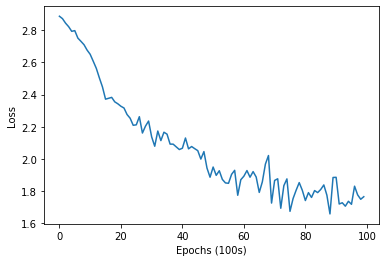

In [0]:
#Let's plot the loss we got during the training procedure
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Epochs (100s)')
plt.plot(all_losses)

In [0]:
## 5. Step - Predict!

In [0]:
input_line = "Daniele"
model_remote = model_pointers["alice"]
line_tensor = lineToTensor(input_line)
line_tensor
line_remote = line_tensor.send(alice)
hidden = model_remote.initHidden()
hidden_remote = hidden.copy().send(alice)
hidden_remote
with torch.no_grad():
    for i in range(line_remote.shape[0]):
        output, hidden_remote = model_remote(line_remote[i], hidden_remote)
        
n_predictions = 3
topv, topi = output.copy().get().topk(n_predictions, 1, True)
topv

predictions = []


for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

(-1.42) Irish
(-1.65) French
(-2.00) Czech


In [0]:
def predict(model, input_line, worker, n_predictions=3):
    model = model.copy().get()
    print('\n> %s' % input_line)
    model_remote = model.send(worker)
    line_tensor = lineToTensor(input_line)
    line_remote = line_tensor.copy().send(worker)
    #line_tensor = lineToTensor(input_line)
    #output = evaluate(model, line_remote)
    # Get top N categories
    hidden = model_remote.initHidden()
    hidden_remote = hidden.copy().send(worker)
        
    with torch.no_grad():
        for i in range(line_remote.shape[0]):
            output, hidden_remote = model_remote(line_remote[i], hidden_remote)
        
    topv, topi = output.copy().get().topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [0]:
predict(model_pointers["alice"], "Qing", alice)


> Qing
(-1.10) Chinese
(-1.45) Korean
(-2.72) German
